In [1]:
import os
import random
from random import randrange
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from datasets import PartDataset
from pointnet import PointNetCls
import torch.nn.functional as F
import matplotlib.pyplot as plt
import open3d as o3
import download
from open3d import JVisualizer
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

In [2]:
# General parameters
NUM_POINTS = 10000
MODEL_PATH = './cls_model.pth'
DATA_FOLDER = './shapenetcore_partanno_segmentation_benchmark_v0'

# download dataset and pre-trained model
download.download_contents()

Model file already downloaded in ./cls_model.pth
Dataset file already downloaded in ./shapenetcore_partanno_segmentation_benchmark_v0.zip


0

In [3]:
# Create dataset object
test_dataset_seg = PartDataset(
    root=DATA_FOLDER,
    train=False,
    classification=False,
    npoints=NUM_POINTS)

# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}


In [4]:
# Create the classification network from pre-trained model
classifier = PointNetCls(k=len(classes_dict.items()), num_points=NUM_POINTS)
if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

PointNetCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=10000, stride=10000, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

In [5]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

JVisualizer with 1 geometries

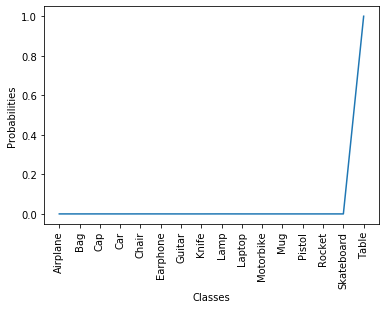

Your object is a [Table] with probability 0.999. Press enter to continue!


In [6]:
# Three.js based visualizer
visualizer = JVisualizer()

# Basic inference and visualization loop
MAX_SAMPLES = 15
for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    visualizer.clear()
    clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    visualizer.add_geometry(cloud)
    visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))
    